In [202]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [227]:
cases = pd.read_csv('1_owid/owid-covid-data.csv')
deaths = pd.read_csv('country_ages.csv')
deaths['Value'] = deaths['Value'].apply(lambda x: x.replace(',', ''))
deaths['Value'] = deaths['Value'].apply(lambda x: x.replace(':', ''))
late_dates = ['2021W01', '2021W02', '2021W03', '2021W04', '2021W05']
deaths = deaths[~deaths['TIME'].isin(late_dates)]

inval_groups = ['Total']
deaths_total = deaths[deaths['AGE'].isin(inval_groups)]
deaths = deaths[~deaths['AGE'].isin(inval_groups)]
deaths_total['Value'] = pd.to_numeric(deaths_total['Value'])
deaths['Value'] = pd.to_numeric(deaths['Value'])
deaths.head()

,GEO,TIME,UNIT,SEX,AGE,Value,Flag and Footnotes
1,Belgium,2017W52,Number,Total,Less than 5 years,11.0,NaN
2,Belgium,2017W52,Number,Total,From 5 to 9 years,2.0,NaN
3,Belgium,2017W52,Number,Total,From 10 to 14 years,1.0,NaN
4,Belgium,2017W52,Number,Total,From 15 to 19 years,4.0,NaN
5,Belgium,2017W52,Number,Total,From 20 to 24 years,3.0,NaN


In [228]:
cases.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [229]:
states = deaths.GEO.unique()

df = pd.DataFrame({'State': states})
df['Total Deaths'] = df['State'].apply(lambda x: cases[(cases['location'] == x) & (cases['date'] == '2021-01-04')]['total_deaths'].sum())
group_mappings = {
    'Deaths less than 25 years': ['Less than 5 years', 'From 5 to 9 years', 'From 10 to 14 years', 'From 15 to 19 years', 'From 20 to 24 years'],
    'Deaths from 25 to 44 years': ['From 25 to 29 years', 'From 30 to 34 years', 'From 35 to 39 years', 'From 40 to 44 years'],
    'Deaths from 45 to 64 years': ['From 45 to 49 years', 'From 50 to 54 years', 'From 55 to 59 years', 'From 60 to 64 years'],
    'Deaths from 65 to 74 years': ['From 65 to 69 years', 'From 70 to 74 years'],
    'Deaths 75 years and over': ['From 75 to 79 years', 'From 80 to 84 years', 'From 85 to 89 years', '90 years or over']
}
for g in group_mappings:
    df[g] = df['State'].apply(lambda x: deaths[(deaths['GEO'] == x) 
                                               & (deaths['AGE'].isin(group_mappings[g]))]['Value'].sum()
                             * df[df['State'] == x]['Total Deaths'].sum() 
                              / deaths_total[deaths_total['GEO'] == x]['Value'].sum())
    
df = df[df['State'].isin(cases.location.unique().tolist())]
# df

In [230]:
ifr = {
    25: 0.0000972,
    44: 0.00116,
    64: 0.00939,
    74: 0.0487,
    100: 0.142
}
# df['Total Deaths'] = df.apply(lambda x: x['Deaths less than 25 years']
#                                    + x['Deaths from 25 to 44 years']
#                                    + x['Deaths from 45 to 64 years']
#                                    + x['Deaths from 65 to 74 years']
#                                    + x['Deaths 75 years and over'], axis=1)
# df['Reported Deaths'] = df['State'].apply(lambda x: cases[cases['location'] == x].iloc[0]['Total Deaths'])

df['Calculated Cases'] = df.apply(lambda x: x['Deaths less than 25 years']/ifr[25]
                                   + x['Deaths from 25 to 44 years']/ifr[44]
                                   + x['Deaths from 45 to 64 years']/ifr[64]
                                   + x['Deaths from 65 to 74 years']/ifr[74]
                                   + x['Deaths 75 years and over']/ifr[100]
                                  , axis=1)

In [231]:
df['Reported Cases'] = df['State'].apply(lambda x: cases[(cases['location'] == x) & (cases['date'] == '2021-01-04')]['total_cases'].sum())
df['Cases Difference'] = abs(df['Calculated Cases'] - df['Reported Cases'])/df['Reported Cases']
# adjust for countries with too small sample size
df = df[df['Total Deaths'] > 300]
df = df[~(df['State'] == 'Luxembourg')]
# df

In [235]:
tests = pd.read_csv('2_ecdc/testing.csv')
df['Tests Performed'] = df['State'].apply(lambda x: tests[tests['country'] == x]['testing_rate'].sum()
                                          /len(tests[tests['country'] == x]['testing_rate']))
corr, _ = pearsonr(df['Tests Performed'], df['Cases Difference'])
print(corr)

-0.5164887110847012


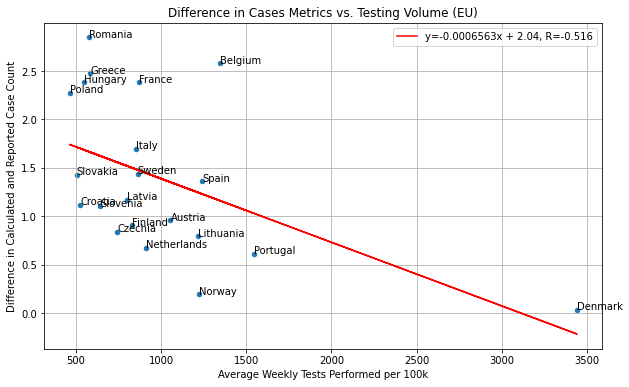

In [238]:
fig, ax = plt.subplots()
df.plot('Tests Performed', 'Cases Difference', kind='scatter', ax=ax, figsize=(10,6))
df_by_state = df.set_index('State')
for k, v in df_by_state[['Tests Performed', 'Cases Difference']].iterrows():
    ax.annotate(k, v)

z = np.polyfit(df['Tests Performed'], df['Cases Difference'], 1)
p = np.poly1d(z)
plt.plot(df['Tests Performed'],p(df['Tests Performed']),"r-", 
         label='y=' + str(round(z[0], 7)) + 'x + ' + str(round(z[1], 2)) + ', R=' + str(round(corr, 3)))
plt.xlabel('Average Weekly Tests Performed per 100k')
plt.ylabel('Difference in Calculated and Reported Case Count')
plt.title('Difference in Cases Metrics vs. Testing Volume (EU)')
plt.grid(True)
plt.legend()

In [239]:
df

,State,Total Deaths,Deaths less than 25 years,Deaths from 25 to 44 years,Deaths from 45 to 64 years,Deaths from 65 to 74 years,Deaths 75 years and over,Calculated Cases,Reported Cases,Cases Difference,Tests Performed
0,Belgium,19750.0,155.457605,373.831809,2329.381270,3167.328796,13724.000520,2.331383e+06,650887.0,2.581855,1344.301360
1,Czechia,12070.0,82.057492,287.521366,1638.386516,2847.715129,7214.319497,1.375838e+06,746714.0,0.842523,742.844292
2,Denmark,1389.0,11.238434,22.334185,168.098107,276.369806,910.959466,1.648673e+05,171436.0,0.038316,3441.667085
5,Greece,5011.0,31.118986,82.761814,535.673629,710.391502,3650.632440,4.888436e+05,140526.0,2.478670,584.667082
6,Spain,51078.0,283.002403,805.509112,5793.833077,6911.658527,37281.235697,4.627440e+06,1958844.0,1.362332,1239.565783
7,France,65549.0,648.711293,1325.415627,8002.888099,9939.725270,45316.480364,9.192093e+06,2717059.0,2.383104,870.215970
8,Croatia,4126.0,28.664218,69.949815,582.053428,787.315585,2657.839544,4.520713e+05,213319.0,1.119226,525.189108
9,Italy,75680.0,361.483590,915.572779,6775.528482,10064.510351,57562.904798,5.841858e+06,2166244.0,1.696768,854.239783
11,Latvia,692.0,5.170069,25.181939,124.830583,129.879856,406.542954,9.372248e+04,43118.0,1.173628,801.732112
12,Lithuania,1950.0,14.944790,66.972436,361.769180,349.025438,1157.288156,2.653317e+05,147997.0,0.792818,1214.312266
